In This notebook you'll find my very first data exploration and modeling (must not be consider) 

In [31]:
import pandas as pd
import modules.vertica as vertica
import pandas as pd
import os
import json 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#### Load datasets

In [32]:
dim_donor = pd.read_csv("../../data/dim_donor.csv")
dim_patient = pd.read_csv("../../data/dim_patient.csv")
fct_haemodynamic = pd.read_csv("../../data/fct_haemodynamic.csv")
fct_neurology = pd.read_csv("../../data/fct_neurology.csv")
fct_respiratory = pd.read_csv("../../data/fct_respiratory.csv")
fct_temperature = pd.read_csv("../../data/fct_temperature.csv")
clean_data = pd.read_csv("../../data/clean_data/clean_Bloc_files.csv")

In [41]:
dim_patient.shape

(411, 91)

In [43]:
fct_neurology.id_patient.nunique()

94

In [3]:
var_to_drop = list()
var_to_drop.append('id_patient')
var_category = list()
var_continuous = list()

In [4]:
var_continuous = [
    
   'los_total_ventilation',
'time_on_waiting_liste',
'first_lung_ischemic_time',
'second_lung_ischemic_time',
'los_first_ventilation',
'ecmo_duration',
'prdc',
'ffp',
'fluid_support',
'estimated_blood_loss', 
    'moment_de_pose_ecmo'
 ]

In [5]:
var_category = [
    
'preoperative_icu',
'preoperative_vasopressor',
'preoperative_mechanical_ventilation',
'super_urgence',
'other_organ_transplantation',
'pathologie',
'retransplant',
'transplanted_twice_during_study_period',
'thoracic_surgery_history',
'preoperative_pulmonary_hypertension',
'plasmapherese',
'pfo',
'second_lung_ischemic_time',
'preoperative_ecmo',
'postoperative_ecmo',
'only_intraoperative_ecmo',
'ecmo_during_surgery',
'cec',
'cause_ecmo',
'pulmonary_reduction',
'adrenaline_perop',
'platelets',
'no_dependence',
'cause_no_dependance',
'adre_end_surgery']

####  drop postoperative features

In [6]:
columns_postoperatoire = ['pgd_h0' , 
'p_f_h0' , 
'p_f_end_surgery' , 
'pgd_end_surgery' , 
'time_last_pf', 
'pdg_h24' , 
'pgd_h48',
'pgd3',
'date_de_deces',
'30_d_survival',
'in_hospital_mortality'] 

dim_patient.drop(columns_postoperatoire, axis = 1, inplace = True)

##### Time based features

dayofweek, month  (date of surgery)

next steps : add internship calendar 

In [7]:
dim_patient.date_transplantation = pd.to_datetime(dim_patient.date_transplantation)
dim_patient['month'] = dim_patient.date_transplantation.dt.month
dim_patient['dayofweek'] = dim_patient.date_transplantation.dt.dayofweek

dim_patient['diff transplantation sortie'] = pd.to_datetime(dim_patient.date_transplantation) - pd.to_datetime(dim_patient.date_sortie_bloc)
dim_patient['diff transplantation sortie']= dim_patient['diff transplantation sortie'].dt.days 

dim_patient.heure_arrivee_rea = dim_patient.heure_arrivee_rea.map(lambda x : x.split(':')[0])


In [8]:
var_continuous.append('diff transplantation sortie')
var_to_drop.append('date_sortie_bloc')
var_to_drop.append('date_transplantation')
var_category = var_category + ['ecmo_during_surgery','only_intraoperative_ecmo','preoperative_ecmo','exvivo','pfo','plasmapherese','preoperative_pulmonary_hypertension','thoracic_surgery_history','transplanted_twice_during_study_period','retransplant','pathologie','other_organ_transplantation','super_urgence','preoperative_mechanical_ventilation','preoperative_vasopressor','preoperative_icu','diabetes','sexe','exclusion_lactate','month', 'dayofweek', 'exclusion_plasmapherese', 'exclusion_pf','exclusion_ino']
var_category = var_category + ['cec','cause_ecmo']
var_continuous = var_continuous + ['second_lung_ischemic_time', 'first_lung_ischemic_time','time_on_waiting_liste','heure_arrivee_rea', 'age', 'body_mass_index']

In [9]:
init_columns_list = list(dim_patient.columns)

#### Time series features extraction

In [10]:
def features_cat(df , path = "features.json") : 
    
    rules = get_json(path)
    for r in rules.keys() :
        
        try : 
            
            cond_str = get_conditions(rules[r])
            q = 'df["{}"] = df["{}"].map(lambda x : {})'.format(r, rules[r]["name"], cond_str)
            exec(q)
        except : 
            print("could not create columns {}".format(rules[r]["name"]))
            pass
        
    return(df)

def get_conditions(conditions):
    
    cond = str()
    for i in conditions["conditions"].keys():
        
        cond = cond + "{} if   {}  else ".format('"' + conditions["conditions"][i]  + '"' , i )

    cond = cond + '"unknown"'
    return(cond)

def get_json(path = "features.json") : 
    
    f = json.load(open(path))
    
    return(f)

def features_cat(df , dataset_name, path = "features_haemodynamic.json") : 


    conditions = get_json(path)
    
    for i in conditions.keys():
        
        cond = get_conditions(conditions[i])    
        name_new_col = conditions[i]['name']
        col = i

        q = '{}["{}"] = {}["{}"].map(lambda x : {})'.format(dataset_name , name_new_col, dataset_name ,  col , cond)
    
        exec(q)
    

def get_conditions(conditions) :

    q1 = " 'normal' if x >= {}  and  x <= {} else  " .format(conditions['normalite'][0], conditions['normalite'][1])
    q2 = " 'anormal' if x > {} and x < {} else ".format(conditions['etendue'][0], conditions['normalite'][0])
    q3 = "'anormal' if x > {} and x < {} else ".format(conditions['normalite'][1], conditions['etendue'][1])
    q4 = " 'dirty' if x < {} and x > {} else ".format(conditions['etendue'][0], conditions['etendue'][1])
    q5 = "'null' if x == 0 else 'unkown'"
    
    
    
    cond = q1 + q2 + q3 + q4 + q5
    
    #print(cond)
    
    return(cond)
    

#### Encode time series

create categorical data based on treshold given by DR (https://github.com/dataforgoodfr/batch_5_transplant/blob/master/data/README.md) 

features_cat(fct_haemodynamic, 'fct_haemodynamic', 'features_haemodynamic.json')
features_cat(fct_respiratory, 'fct_respiratory', 'features_respiratory.json')
features_cat(fct_neurology, 'fct_neurology', 'features_neurology.json')
features_cat(fct_temperature, 'fct_temperature', 'features_temperature.json')

fct_neurology.time = fct_neurology.time.map(lambda x: pd.to_datetime(x.replace(" ", ""),  format = '%H:%M'))


In [11]:
def features_from_ts(df, dim_patient):

    columns_list = df.columns
    ids_col = ['id_patient', 'time', 'Unnamed: 0']
    cat_col = [i  for i in columns_list if i.endswith('_cat') ]
    quant_col = list(set(columns_list) - set(ids_col) - set(cat_col))
    
    mean_ds = df.groupby("id_patient").mean()[quant_col].reset_index()
    var_ds = df.groupby("id_patient").var()[quant_col].reset_index()
    max_ds = df.groupby("id_patient").max()[quant_col].reset_index()
    
    mean_ds.columns = ['id_patient'] + [i + '_mean_ds' for i in mean_ds.columns if i != 'id_patient']
    var_ds.columns = ['id_patient'] + [i + '_var_ds' for i in var_ds.columns if i != 'id_patient']
    max_ds.columns =['id_patient'] + [i + '_max_ds' for i in max_ds.columns if i != 'id_patient']

    dim_patient = pd.merge(dim_patient, mean_ds, how = 'left', on = 'id_patient')
    dim_patient = pd.merge(dim_patient, var_ds, how = 'left', on = 'id_patient')
    dim_patient = pd.merge(dim_patient, max_ds, how = 'left', on = 'id_patient')

    cat_df = df[cat_col] 
    cat_df.index = df.id_patient
    cat_df = (cat_df == 'anormal').reset_index().groupby('id_patient').sum()
    cat_df.columns = [i + "_anormal_sum" for i in cat_df.columns]
    dim_patient = pd.merge(dim_patient, cat_df, how = 'left', on = 'id_patient')
    
    return(dim_patient)
    

dim_patient = features_from_ts(fct_neurology, dim_patient)
dim_patient = features_from_ts(fct_haemodynamic, dim_patient)
dim_patient = features_from_ts(fct_temperature, dim_patient)
dim_patient = features_from_ts(fct_neurology, dim_patient)

#### surgery duration

length = dict()
var_continuous.append('length_lt')

for i in fct_neurology.id_patient.unique() : 
    max_ts = fct_neurology[fct_neurology.id_patient == i].time.max()
    min_ts = fct_neurology[fct_neurology.id_patient == i].time.min()
    x = (max_ts - min_ts)
    x = x.seconds/60
    length[i] = x
    
length_lt = pd.DataFrame.from_dict(length, orient = 'index').reset_index()    
length_lt.columns = ["id_patient", "length_lt"]

dim_patient["patient_code"] = dim_patient["id_patient"]
length_lt.id_patient = length_lt.id_patient.astype(int)

dim_patient = pd.merge(dim_patient, length_lt, how = 'left', on = "id_patient")


quant_col = [i  for i in dim_patient.columns if 'mean' in i ]
quant_col  = quant_col + [i  for i in dim_patient.columns if 'var' in i ]
quant_col = quant_col + [i  for i in dim_patient.columns if 'max' in i ]

dum = pd.get_dummies(dim_patient[var_category])
dim_patient[dum.columns] = dum
#dim_patient.drop(var_category[0], axis = 1, inplace = True)

### Exploration

In [12]:
col = list(set(var_continuous+var_category))

In [13]:
X = dim_patient[col]

In [14]:
def get_heatmap(df):
    
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

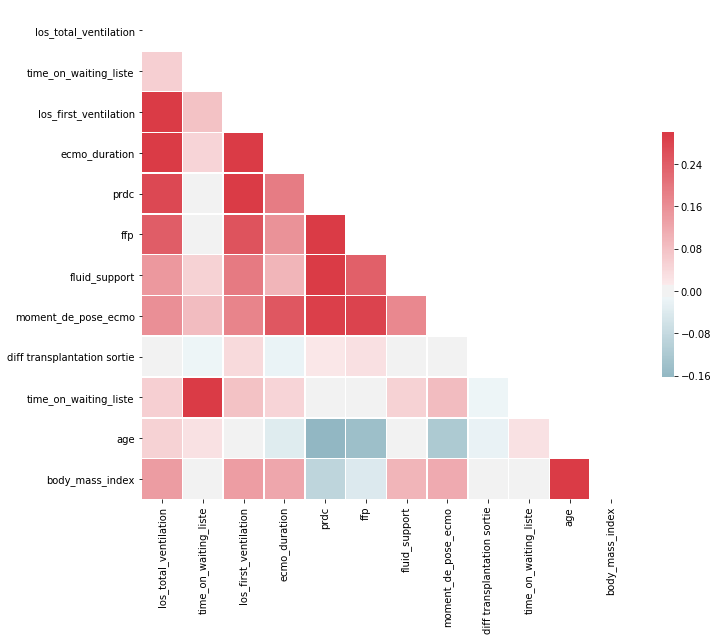

In [15]:
get_heatmap(X[var_continuous])

No significant correlation between the quantitative features.

In [16]:
dim_patient['target'] = np.nan
dim_patient['target'][(dim_patient["immediate_extubation"] == 1) & (dim_patient["secondary_intubation"] == 0)] = 'immediate extubation has been successfull'
dim_patient['target'][(dim_patient["immediate_extubation"] == 1) & (dim_patient["secondary_intubation"] == 1)] = 'immediate extubation has not been successfull'
dim_patient['target'][(dim_patient["immediate_extubation"] == 0) & (dim_patient["secondary_intubation"] == 0)] = 'no immediate extubation'
dim_patient['target'][(dim_patient["immediate_extubation"] == 0) & (dim_patient["secondary_intubation"] == 1)] = 'auto extubation ? '


/home/vagrant/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/vagrant/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vagrant/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.

In [17]:
y = dim_patient["target"]
y_filter = (y == 'immediate extubation has been successfull') | (y == 'immediate extubation has not been successfull')
y = y[y_filter]
X = X[y_filter]

dim_patient['target'].value_counts()/len(dim_patient['target'])*100


no immediate extubation                          58.150852
immediate extubation has been successfull        28.953771
auto extubation ?                                 8.272506
immediate extubation has not been successfull     3.892944
Name: target, dtype: float64

In [18]:
X.replace('NF', np.nan, inplace = True ) 

#### impute missing values - quick n dirty

In [19]:
print(X.isnull().sum())
X.fillna(X.mean(), inplace = True)

pathologie                                0
month                                     0
plasmapherese                             0
prdc                                      0
first_lung_ischemic_time                  1
other_organ_transplantation               0
moment_de_pose_ecmo                       1
preoperative_vasopressor                  0
adrenaline_perop                          0
exclusion_lactate                         0
exclusion_plasmapherese                   0
postoperative_ecmo                        0
pfo                                       2
platelets                                 0
age                                       0
thoracic_surgery_history                  0
ecmo_duration                             0
cause_ecmo                                0
exvivo                                    0
retransplant                              0
diabetes                                  0
exclusion_ino                             0
super_urgence                   

In [20]:
X.replace(np.nan, 0, inplace = True)

### très crado mais il est tard

labels are highly unbalanced, sampling methods must be used to rebalanced class. 

In [21]:
y.value_counts()/len(y)*100

immediate extubation has been successfull        88.148148
immediate extubation has not been successfull    11.851852
Name: target, dtype: float64

####  Quick n Dirty RF

In [22]:
dum = pd.get_dummies(X[var_category])
X = pd.concat([dum, X], axis = 1)
X.drop(var_category, inplace = True, axis = 1)


In [23]:

y = pd.get_dummies(y)
y = y['immediate extubation has been successfull']

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=10)

scores.mean()

/home/vagrant/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vagrant/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vagrant/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vagrant/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vagrant/miniconda3/lib/python3

0.9417582417582417

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

confusion_matrix(y_test, y_pred)

/home/vagrant/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[ 2,  3],
       [ 0, 40]])

In [26]:
y_test.value_counts()

1    40
0     5
Name: immediate extubation has been successfull, dtype: int64

In [27]:
X['target'] = y 
X.to_csv('../../data/clean_dataset_ml.csv')

In [30]:
principalComponents

array([[-3.77006520e+02,  1.08245764e+03],
       [-4.45302934e+02, -3.08816722e+02],
       [-9.84920765e+01,  5.37349653e+02],
       [-4.22043897e+02,  1.02359774e+02],
       [-1.82845297e+02,  5.33693719e+01],
       [-4.01246380e+02,  8.28772063e+02],
       [-2.34505756e+01,  1.16562387e+03],
       [-4.17315841e+02,  1.80350331e+02],
       [-4.46340701e+02, -1.51291773e+02],
       [-5.15008650e+02, -1.50297236e+03],
       [-4.43695566e+02, -3.70072011e+02],
       [-4.19438669e+02, -1.95590092e+01],
       [-4.77405837e+02, -1.08605594e+03],
       [-6.42819936e+01,  1.63598392e+03],
       [-3.90432427e+02,  7.78099712e+02],
       [-5.09248535e+02, -1.88346911e+03],
       [-4.64952234e+02, -9.01576838e+02],
       [-4.64968865e+02, -8.82176028e+02],
       [-4.32541983e+02,  1.32757669e+03],
       [-3.98521396e+02,  5.12397063e+02],
       [-2.93195512e+02, -5.38802206e+02],
       [-2.45276867e+02, -1.31802435e+03],
       [-3.77226989e+02,  1.11186472e+03],
       [-4.